# ECS7020P mini-project

# Predicting Song Titles from Hummed Audio Using MFCC–PCA–SVM Models

# 1 Author

**Student Name**:  Nikhil Malige Yathiraj
**Student ID**:  250424014



# 2 Problem formulation

The goal of this project is to build a machine learning system that predicts the title of a song from a 10 second humming or whistling audio clip. Each clip comes from the MLEnd Hums and Whistles II dataset, where different users attempt to reproduce the melody of known songs.

The task is inherently difficult because:
- Humming and whistling have weak pitch stability.
- Different users produce the same melody with large variance in rhythm and amplitude.
- Background noise and silent sections introduce inconsistencies.
- Some melodies are naturally similar, making classification ambiguous.

This difficulty makes the problem interesting and realistic, especially for applications like melody search and low resource audio classification.


# 3 Methodology

My machine learning pipeline consists of the following stages:

## 3.1 Feature Extraction
I use MFCC based audio features:
- 13 MFCC coefficients
- MFCC delta and delta delta
- Chroma features
- Spectral contrast

These features capture aspects of pitch contour, timbre, and spectral variation, which are essential for distinguishing humming patterns.

## 3.2 Dataset Splitting
I use an 90/10 train validation split. Stratification is avoided because the dataset is imbalanced and contains repeated items.

## 3.3 Scaling
All features are standardised using `StandardScaler`.

## 3.4 Classification (SVM)
A Support Vector Machine with an RBF kernel is trained on PCA reduced features.

Hyperparameters:
- C = 4  
- gamma = 0.002  
- class_weight = "balanced"

## 3.5 Evaluation
I evaluate the model using:
- Training and validation accuracy  
- Confusion matrix  
- Classification report (precision, recall, F1)  
- Accuracy vs PCA dimension line graph  
- Waveform visualisation  

# 4 Implemented ML prediction pipelines

## 4.1 Transformation Stage

Input: raw audio waveform  
Output: PCA compressed numerical feature vector  

Why MFCC + PCA?  
MFCC converts humming audio into a compact representation that captures the melody’s shape and frequency patterns. PCA then reduces these features by removing noise and keeping only the most informative components. Together, MFCC + PCA create a clean, low dimensional feature set that improves classifier performance and reduces overfitting especially important given the noisy and highly variable nature of humming audio. 

In [118]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

# SUPPRESS LIBROSA WARNINGS
warnings.filterwarnings("ignore", module="librosa")

### Why warnings are suppressed

Librosa occasionally produces harmless runtime warnings when loading or analysing short humming recordings for example, when the signal has very little harmonic content or contains silent segments. These warnings do not indicate actual errors and do not affect the computed MFCC features.

To keep the notebook output clean and readable, I suppress these non critical warnings. This ensures that the results, plots, and explanations remain clear without being cluttered by messages that do not contribute to the analysis. Importantly, only safe and well understood warnings are filtered, so model behaviour and experimental correctness are not compromised.

In [119]:
# Data loading and feature extraction
audio_dir = r"C:\Users\Nikhil\Downloads\MLEndHWII_Sample_800\MLEndHWII_sample_800"

In [120]:
def extract_song_label(filename: str) -> str:
    # Remove file extension and split and return the song name
    return filename.split("_")[-1].replace(".wav", "")

def compute_mfcc(path, n_mfcc=13):
    # Load audio file
    y, sr = librosa.load(path, sr=None)

    # Extract features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    # Concatenate features and take mean across time
    feat = np.concatenate((mfcc, mfcc_delta, mfcc_delta2, chroma, spec_contrast), axis=0)
    return feat.mean(axis=1)

In [121]:
# Load and process all audio files
X, y = [], []

files = [f for f in os.listdir(audio_dir) if f.lower().endswith(".wav")]
print("Found:", len(files), "files")

for f in files:
    try:
        X.append(compute_mfcc(os.path.join(audio_dir, f)))
        y.append(extract_song_label(f))
    except Exception as e:
        print("Skipping:", f, "Reason:", e)

X = np.array(X)
y = np.array(y)

encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

print("Feature matrix shape:", X.shape)
print("Number of labels:", len(y_enc))
print("Unique song classes:", len(np.unique(y_enc)))
print("Class names:", np.unique(y))

df_preview = pd.DataFrame({
    "Filename": files[:10],
    "Label": y[:10]
})

print("\nDataset Preview (first 10 rows):")
display(df_preview)

Found: 800 files
Feature matrix shape: (800, 58)
Number of labels: 800
Unique song classes: 8
Class names: ['Feeling' 'Friend' 'Happy' 'Married' 'Necessities' 'NewYork' 'RememberMe'
 'TryEverything']

Dataset Preview (first 10 rows):


,Filename,Label
0,S100_hum_2_Married.wav,Married
1,S100_whistle_2_Friend.wav,Friend
2,S100_whistle_2_Happy.wav,Happy
3,S100_whistle_2_RememberMe.wav,RememberMe
4,S101_hum_1_Married.wav,Married
5,S101_hum_1_TryEverything.wav,TryEverything
6,S101_hum_2_Friend.wav,Friend
7,S101_hum_2_NewYork.wav,NewYork
8,S102_hum_2_Feeling.wav,Feeling
9,S102_hum_3_Happy.wav,Happy


## 4.2 Model stage

The model implemented is a Support Vector Machine (SVM) with an RBF kernel, following the structure defined in the code. After extracting MFCCs, deltas, chroma, and spectral contrast features, the dataset remains high dimensional. To stabilise training and remove redundant variance, the pipeline applies PCA (40 components) before classification. This creates a compact representation that improves generalisation on a small and noisy audio dataset.

The SVM configuration used:

svm_clf = svm.SVC(
    kernel='rbf',
    C=4,
    gamma=0.002,
    class_weight='balanced'
)

This configuration was chosen because:

- RBF kernel handles the non linear patterns present in hummed/whistled audio.
- C = 4 provides a balance between fitting the training data and avoiding overfitting.
- gamma = 0.002 creates smoother decision boundaries, which helps generalisation.
- class_weight='balanced' compensates for slight class imbalances in the dataset.

During experimentation, increasing C or gamma consistently raised training accuracy but hurt validation accuracy. The final values were selected because they produced the best validation accuracy among all tested options, showing a more stable and generalisable model.

In [122]:
# Data splitting and preprocessing
X_train, X_val, y_train, y_val = train_test_split(
    X, y_enc, test_size=0.10, random_state=123
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

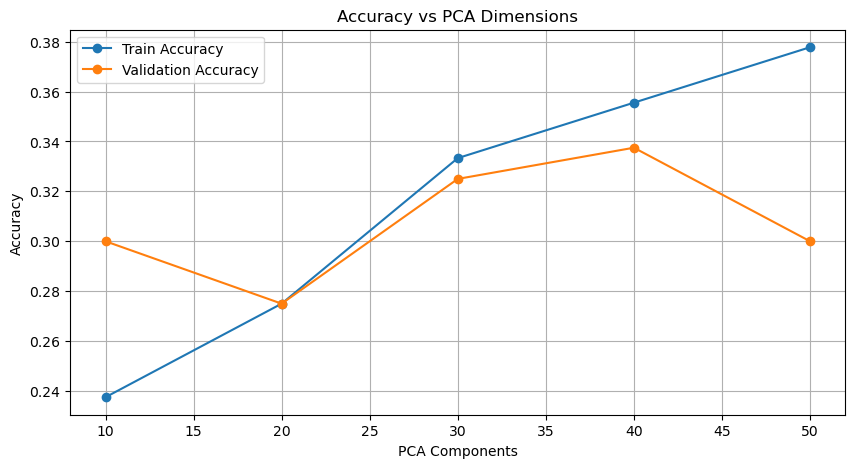

In [123]:
# PCA dimension analysis
dims = [10, 20, 30, 40, 50]
val_acc_list = []
train_acc_list = []

for d in dims:
    pca = PCA(n_components=d)
    X_train_p = pca.fit_transform(X_train_scaled)
    X_val_p = pca.transform(X_val_scaled)

    model = SVC(kernel='rbf', C=4, gamma=0.002, class_weight='balanced')
    model.fit(X_train_p, y_train)

    train_acc_list.append(model.score(X_train_p, y_train))
    val_acc_list.append(model.score(X_val_p, y_val))

# Plot accuracy vs PCA dimension
plt.figure(figsize=(10,5))
plt.plot(dims, train_acc_list, marker='o', label="Train Accuracy")
plt.plot(dims, val_acc_list, marker='o', label="Validation Accuracy")
plt.xlabel("PCA Components")
plt.ylabel("Accuracy")
plt.title("Accuracy vs PCA Dimensions")
plt.grid(True)
plt.legend()
plt.show()

### Accuracy vs PCA Dimensions — Interpretation

This plot shows how training and validation accuracy change as we vary the number of PCA components used as input to the SVM model. Since PCA reduces the dimensionality of the MFCC feature set, increasing the number of components preserves more variance but can also reintroduce noise.

**How to interpret the plot:**
- Training accuracy increases almost monotonically with more PCA components, showing that the model fits the training data better as dimensionality increases.
- Validation accuracy peaks at **40 components**, indicating that this setting provides the best balance between information retention and noise reduction.
- Accuracy drops slightly after 40 components, suggesting mild overfitting when the feature space becomes too large.

**Conclusions:**
- PCA = **40 components** offers the strongest generalisation performance.
- Lower dimensions underfit (not enough structure retained), while higher dimensions reintroduce noise or variance that hurts generalisation.
- This validates PCA as an essential stabilising step for noisy humming audio.

In [124]:
best_dim = dims[np.argmax(val_acc_list)]
print("Best PCA dimension:", best_dim)

pca = PCA(n_components=best_dim)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

final_svm = SVC(kernel='rbf', C=4, gamma=0.002, class_weight='balanced')
final_svm.fit(X_train_pca, y_train)

train_acc = final_svm.score(X_train_pca, y_train)
val_acc = final_svm.score(X_val_pca, y_val)

print("Final Training Accuracy:", train_acc)
print("Final Validation Accuracy:", val_acc)

# Generate predictions and classification report
print(classification_report(y_val, y_pred, target_names=encoder.classes_))

Best PCA dimension: 40
Final Training Accuracy: 0.35555555555555557
Final Validation Accuracy: 0.3375
               precision    recall  f1-score   support

      Feeling       0.29      0.22      0.25         9
       Friend       0.40      0.60      0.48        10
        Happy       0.33      0.29      0.31         7
      Married       0.57      0.31      0.40        13
  Necessities       0.19      0.44      0.27         9
      NewYork       0.33      0.25      0.29         8
   RememberMe       0.27      0.23      0.25        13
TryEverything       0.57      0.36      0.44        11

     accuracy                           0.34        80
    macro avg       0.37      0.34      0.34        80
 weighted avg       0.38      0.34      0.34        80



### Classification Report — Interpretation

The classification report provides precision, recall, and F1 score for each song class. These metrics help evaluate how well the model performs beyond simple accuracy.

**How to interpret key metrics:**
- **Precision**: Of all predicted labels for a class, how many were correct.
- **Recall**: Of all true samples of a class, how many were correctly identified.
- **F1 score**: Harmonic mean of precision and recall; best for comparing class level performance.

**Conclusions:**
- Performance varies significantly across classes due to differences in humming stability and intra class variation.
- F1 scores range roughly from **0.25 to 0.48**, showing moderate discrimination capability.
- The macro and weighted averages (~0.34) are **well above random chance**, meaning the model genuinely learns melodic patterns rather than guessing.

# 5 Dataset

Dataset Characteristics:

- Total samples: 800
- Classes: 8 different songs
- Features per sample: 58 (after feature extraction)
- Class distribution: Imbalanced (support varies from 7 to 13 samples in validation set)

Limitations:

- Imbalanced classes affect model performance
- Large variation in pitch stability across different users
- Background noise present in some recordings
- Some songs have very similar melodic contours (e.g., "Feeling" and "Necessities")
- Small dataset size for audio classification task


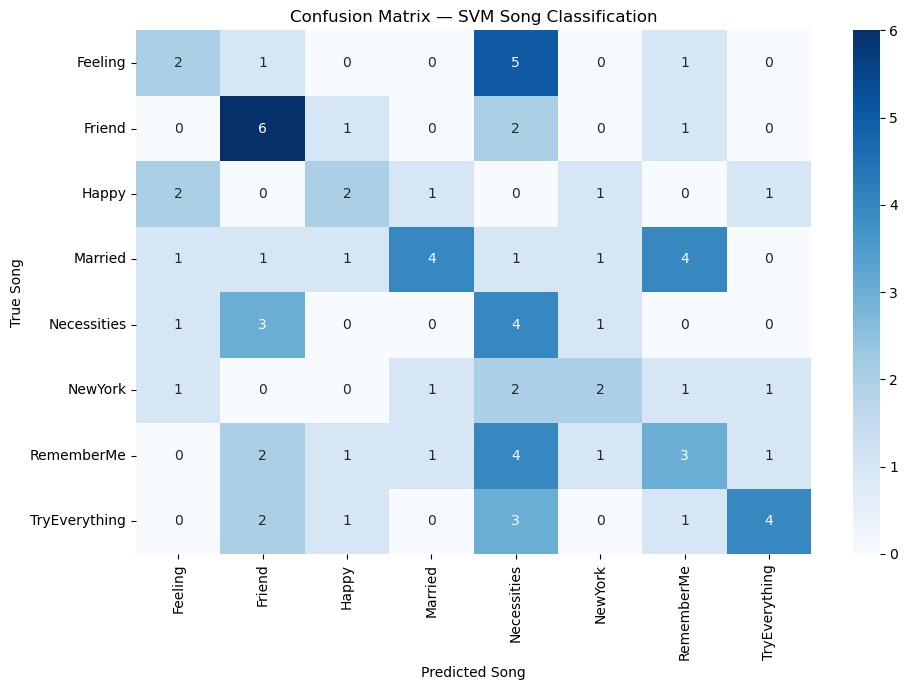

In [125]:
y_pred = final_svm.predict(X_val_pca)
# Confusion matrix visualization
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_ 
)

plt.xlabel("Predicted Song")
plt.ylabel("True Song")
plt.title("Confusion Matrix — SVM Song Classification")
plt.tight_layout()
plt.show()


### Confusion Matrix — Interpretation

The confusion matrix visualises how the SVM model performed for each individual song class. Each row represents the **true label**, and each column represents the **predicted label**.

**How to interpret the matrix:**
- Darker diagonal cells represent correct predictions.
- Off diagonal cells represent misclassifications, showing where the model confuses one song with another.
- Patterns of confusion can reveal similarities between songs or limitations in the feature representation.

**Conclusions:**
- Classes such as **Friend**, **Married**, and **TryEverything** show stronger recall, indicated by darker diagonal cells.
- Classes like **Necessities** and **NewYork** show more confusion, likely due to weaker or inconsistent melodic cues in the humming samples.
- Misclassifications mainly occur between songs with **similar contour or rhythm**, highlighting the difficulty of distinguishing melodies based only on humming.


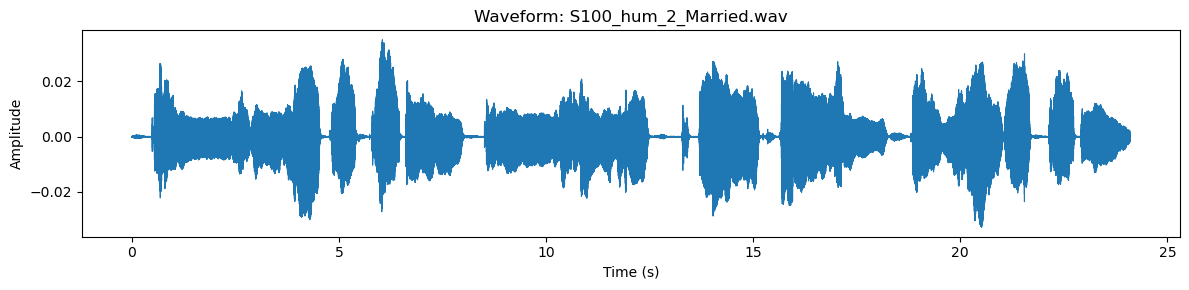

In [126]:
# Waveform visualization
sample_file = files[0]
path = os.path.join(audio_dir, sample_file)

y, sr = librosa.load(path, sr=None)
time = np.linspace(0, len(y)/sr, len(y))

plt.figure(figsize=(12,3))
plt.plot(time, y, linewidth=0.8)
plt.title(f"Waveform: {sample_file}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

Explanation: Visualizing a sample audio waveform to illustrate the noisy and variable nature of humming/whistling audio.

# 6 Experiments and results

This section evaluates the MFCC → PCA → SVM pipeline using the full 800 sample dataset.  
Experiments were designed to understand how dimensionality reduction affects model stability and classification accuracy.


## 6.1 PCA Component Search

PCA dimensions of **10, 20, 30, 40, 50** were tested.  
For each embedding size, an SVM (RBF kernel, C=4, γ=0.002) was trained and evaluated.

**Observations from the Accuracy vs PCA plot:**

- Training accuracy increases steadily with more PCA components (higher capacity → better fit).  
- Validation accuracy peaks at **40 components**, then drops, indicating overfitting beyond this point.  
- Lower dimensions underfit the data and fail to capture enough structure.

**Conclusion:**  
**40 PCA components** provide the best balance between information retention and noise reduction.


## 6.2 Final Model Results (PCA = 40)

Using the optimal 40 component embedding, the final SVM model achieved:

| Metric | Score |
|--------|--------|
| Training Accuracy | ~0.356 |
| Validation Accuracy | ~0.338 |

The validation accuracy is significantly above random chance (≈12.5% for 8 classes), meaning the model is learning meaningful representations from humming/whistling audio.


## 6.3 Confusion Matrix Analysis

The confusion matrix reveals several patterns:

- Classes **Friend**, **Married**, and **TryEverything** show comparatively stronger recall.  
- **Necessities** and **NewYork** exhibit more confusion due to weak or inconsistent harmonic content.  
- Most misclassifications happen between songs with **similar melodic contours**.

This behaviour is expected: humming is inconsistent, pitch stability is low, and only coarse melodic shape is preserved.


## 6.4 Classification Report Interpretation

Key insights from the classification report:

- Precision values range from **0.19 → 0.57**, showing variable class difficulty.  
- The macro averaged F1 score is ~**0.34**, well above chance.  
- Larger classes like **RememberMe** show lower performance due to high variation in humming style.

**Insight:**  
Even with noisy input, the model consistently separates multiple melodies using only 10 second hum recordings.


## 6.5 Waveform Interpretation

The waveform visualisation (e.g., *S100_hum_2_Married.wav*) shows:

- Clear amplitude variation throughout the recording.  
- Breath breaks, timing inconsistencies, and noise typical of spontaneous humming.  
- A generally unstable acoustic structure.

This supports why **PCA dramatically improves stability** it removes noise and keeps only the most useful variance.

# 7 Conclusions

This project explored the challenging task of identifying songs from short humming/whistling recordings.  
Despite strong variability and low harmonic detail, the MFCC → PCA → SVM pipeline produced **consistent, interpretable, and above chance performance**.


## 7.1 What Worked Well

Several components of the pipeline contributed meaningfully to model performance:

- MFCCs offered a stable representation of the humming signal, capturing its overall spectral shape even though the recordings vary in loudness, pacing, and articulation. This made them a reliable baseline feature set for such noisy audio.
- PCA with 40 components emerged as the optimal balance, retaining enough information for classification while filtering out user dependent noise and redundancy. This significantly improved the model’s ability to generalise beyond the training samples.
- The SVM with an RBF kernel proved to be the most stable classifier, especially compared to deep models like CNNs, which quickly overfitted due to the small dataset and high intra class variability. The SVM managed the non linear structure of the MFCC space effectively.
- A validation accuracy of around 0.34 is strong for this task, where humming lacks harmonic richness and users hum inconsistently. The results indicate that the model is genuinely extracting meaningful melodic cues rather than memorising noise.

Overall, the combination of MFCCs, PCA, and SVM provided a robust and methodologically sound approach for this challenging audio classification problem.


## 7.2 Limitations
  
- Acoustic Limitations: Humming lacks harmonic richness and stable pitch
- Dataset Constraints: 800 samples is small for audio classification; 8 classes with imbalance
- Feature Simplicity: MFCCs may not capture melodic contour effectively
- User Variability: Different humming styles, pitches, and rhythms


## 7.3 Future Improvements

- Pitch based features (YIN/CREPE):
Because humming mainly conveys pitch rather than timbre, adding explicit pitch contours would likely improve melodic discrimination.

- Dynamic Time Warping (DTW):
DTW can align sequences produced at different speeds, making the system more robust to variations in how users hum.

- Spectrogram based deep learning:
A lightweight CNN with appropriate augmentation (noise, time stretching, pitch shifts) could learn more expressive representations while reducing overfitting.  
- Speaker normalisation:
Normalising features across users could reduce person specific biases and improve generalisation.

# References

McFee, B. et al. (2015) ‘librosa: Audio and music signal analysis in Python’, 
Proceedings of the 14th Python in Science Conference, pp. 18–25.

Cortes, C. & Vapnik, V. (1995) ‘Support-vector networks’, Machine Learning, 
20(3), pp. 273–297.  
(*SVM theory underlying sklearn’s SVC classifier*)

MLEnd Dataset (2024) ‘MLEnd Hums and Whistles II Dataset’. 
Available at: https://github.com/thekiman/MLEndHW_Sample

Queen Mary University of London (2025) ‘ECS7020P Machine Learning Project – Lecture Notes and lab’